Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования


status: not done

comp: work

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_reg_19_03\models.txt


In [3]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [4]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [5]:
def create_model_rch2(n_iteration, fit=True, n_topics=150):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -20    
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_20_rch2_iter_{}'.format(n_iteration))
    return tmp_model

def create_model_rch3(n_iteration, fit=True, n_topics=20):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = -10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -20
    tmp_model.regularizers['ss_phi_regularizer'].tau = -20    
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_20_rch3_iter_{}'.format(n_iteration))
    return tmp_model

def create_model_fn_20_complex_reg_1(n_iteration):
    n_topics = 20
    common_topics = [u'topic_0', u'topic_1']
    subject_topics = list(set([u'topic_{}'.format(idx) for idx in range(2, 20)]) - set(common_topics))
    tmp_model = create_model_complex(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, 
        seed_value=100 + n_iteration, n_top_tokens=15, p_mass_threshold=0.25, 
        common_topics=common_topics, subject_topics=subject_topics)
    # subject topics
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer_subject', 
        topic_names=subject_topics))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer_subject', 
        topic_names=subject_topics, class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer_subject', 
        topic_names=subject_topics, class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer_subject'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer_subject'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer_subject'].tau = -10

    # common topics
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer_common', 
        topic_names=subject_topics))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer_common', 
        topic_names=subject_topics, class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer_common'].tau = 0.5
    tmp_model.regularizers['ss_phi_regularizer_common'].tau = 0.5

    tmp_model = fit_one_model_complex(plot_maker, batch_vectorizer, models_file, config, 
                                      tmp_model, _n_iterations=20,             
                                      _model_name='model_20_complex_reg_1_iter_{}'.format(n_iteration))
    return tmp_model
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [6]:
models_count = 100
names_list, models_list = [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

name = model_20_rch3_iter_10, n_topics = 20, n_doc_passes = 5, seed_value = 110, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -20
decorrelator_phi_regularizer, tau = -10
ss_phi_regularizer, tau = -20

('Filtered topics: ', [u'topic_1', u'topic_2', u'topic_4', u'topic_6', u'topic_9', u'topic_12', u'topic_18'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило: 0.019 грамматика: 0.017 тип: 0.016 смысл: 0.014 существительное: 0.014
topic_2 | молекула: 0.150 белка: 0.116 белок: 0.092 вирус: 0.066 рецептор: 0.055 опухоль: 0.035 н

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function hellinger_dist at 0x000000000BC90668>, Processed th = 1.0, original columns count = 7     [(u'topic_1', u'topic_5', 0, 5, 0.82660486350134543), (u'topic_2', u'topic_4', 1, 4, 0.46574677761044248), (u'topic_4', u'topic_3', 2, 3, 0.67300596663911616), (u'topic_6', u'topic_2', 3, 2, 0.85415425282786162), (u'topic_9', u'topic_6', 4, 6, 0.79862141645334428), (u'topic_12', u'topic_1', 5, 1, 0.78925030962870424), (u'topic_18', u'topic_0', 6, 0, 0.53621182919225996)]


phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00     7.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       2126.43  2129.29
|phi_ij > 0.2| / n_topics         0.23     0.14
|phi_ij > 0.1| / n_topics         0.89     1.14
|phi_ij > 0.01| / n_topics       27.16    24.57
|phi_ij > 0.05| / n_topics        2.63     3.29
|phi_ij > 0.001| / n_topics      80.26    80.29
topic_kernel_average_size        23.68    56.43
topic_kernel_average_purity       0.63     0.82
topic_kernel_average_contrast     0.78     0.78

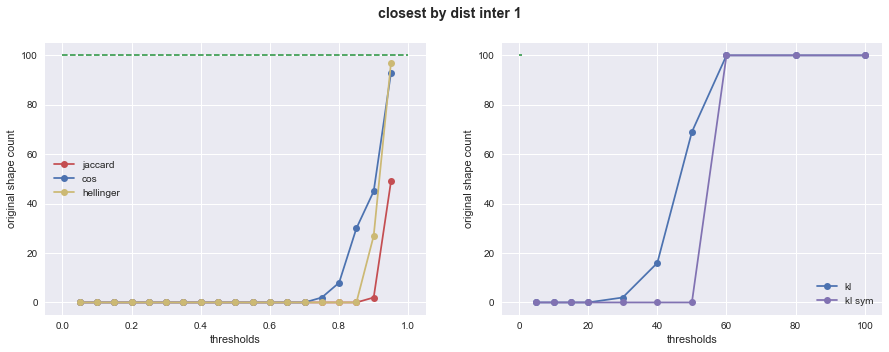

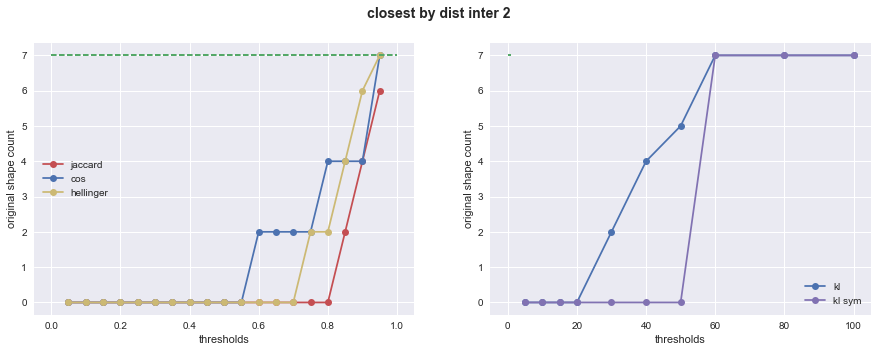

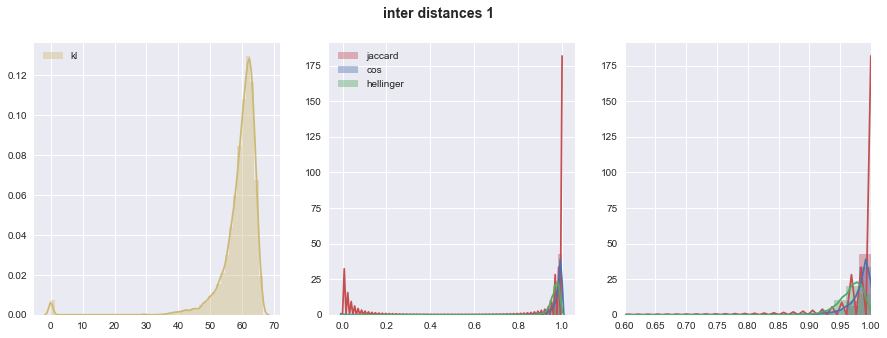

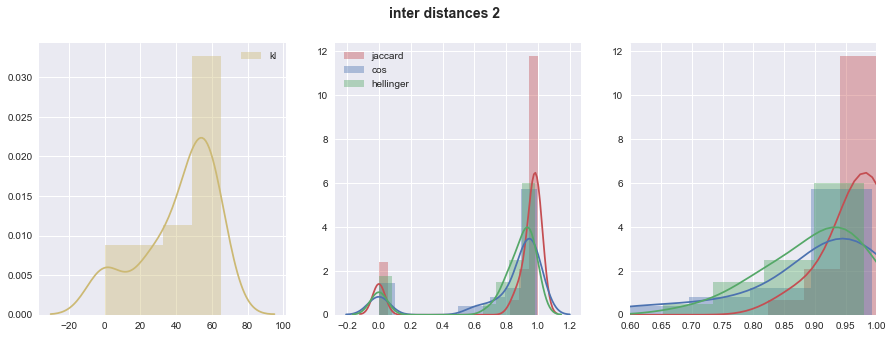

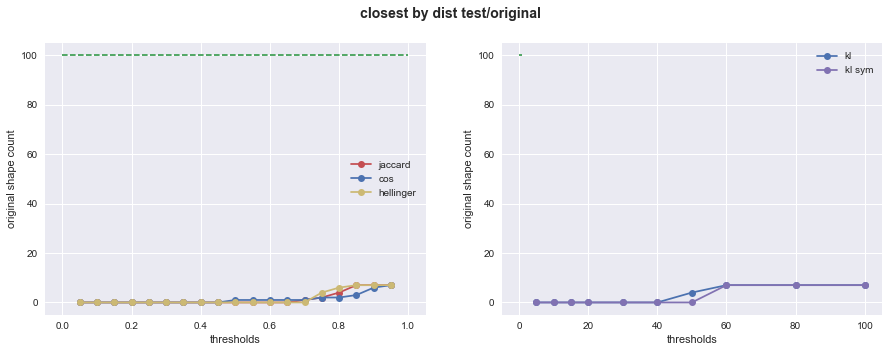

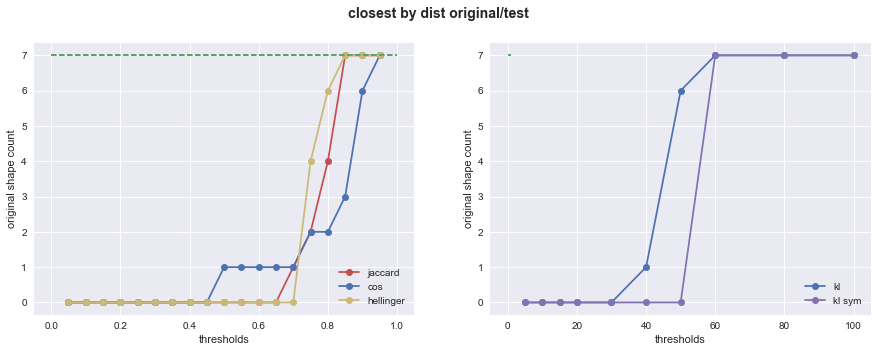

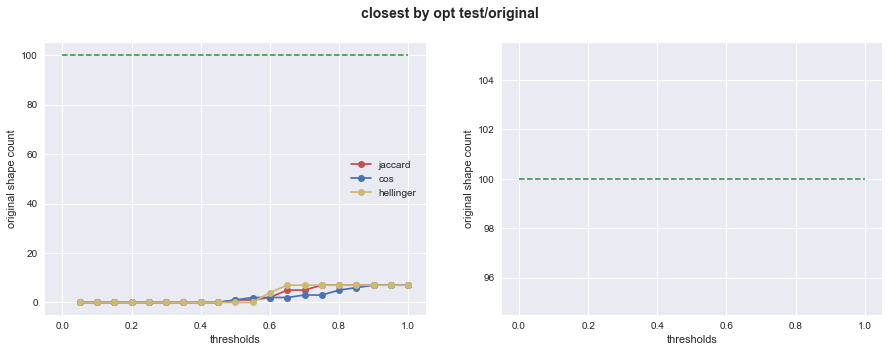

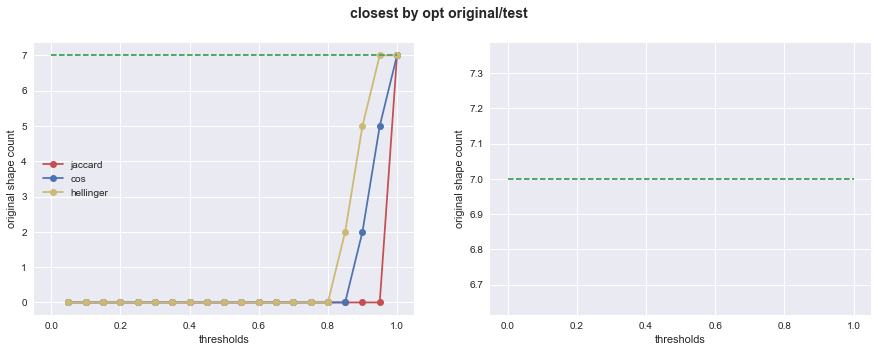

In [11]:
idx = 0
names_list[idx] = [u'model1']
models_list[idx] = create_model_rch3(10)
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* closest by dist: тестовая модель -- темы более близки друг к другу
* inter distances: the same
* closest by dist test/original - оригинальные темы вообще не находит (порог 0.8 - пару тем)
* closest by dist original/test -- интересно, при пороге 0.5 - одну тему (ПОЧЕМУ не симметрично?)
* closest by opt res original/test -- всё хуже, чем по дист. Хотя не должно быть...

name = model_20_rch3_iter_100, n_topics = 20, n_doc_passes = 5, seed_value = 200, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -20
decorrelator_phi_regularizer, tau = -10
ss_phi_regularizer, tau = -20

('Filtered topics: ', [u'topic_2', u'topic_3', u'topic_4', u'topic_12', u'topic_13', u'topic_15', u'topic_17', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило: 0.019 грамматика: 0.017 тип: 0.016 смысл: 0.014 существительное: 0.014
topic_2 | молекула: 0.150 белка: 0.116 белок: 0.092 вирус: 0.066 рецептор: 0.055 

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00     8.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2144.50
|phi_ij > 0.2| / n_topics         0.23     0.62
|phi_ij > 0.1| / n_topics         0.89     2.00
|phi_ij > 0.01| / n_topics       27.16    18.62
|phi_ij > 0.05| / n_topics        2.63     4.50
|phi_ij > 0.001| / n_topics      80.26    67.50
topic_kernel_average_size        23.68    50.38
topic_kernel_average_purity       0.63     0.80
topic_kernel_average_contrast     0.78     0.76

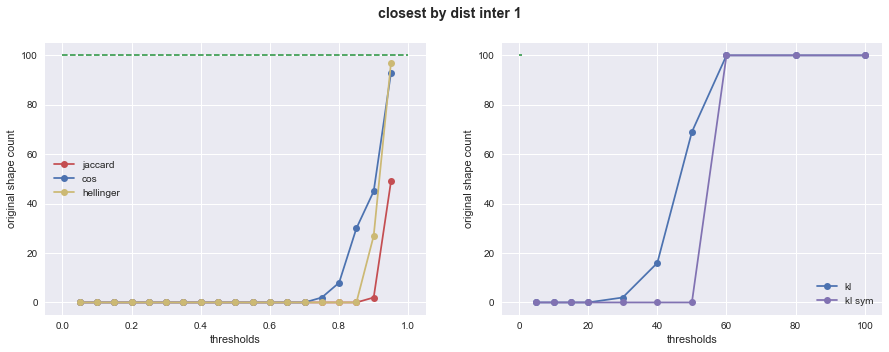

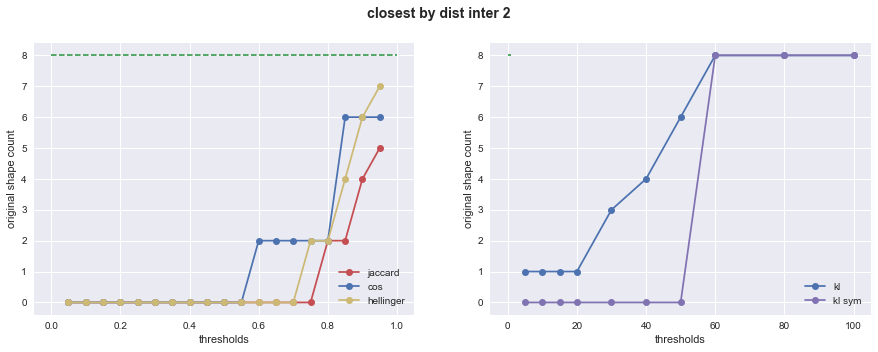

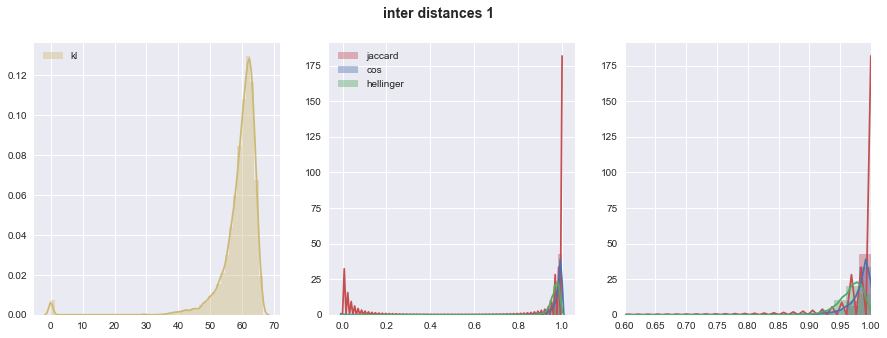

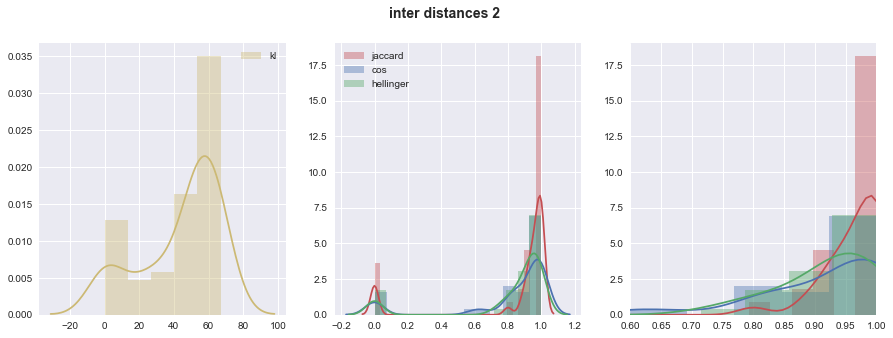

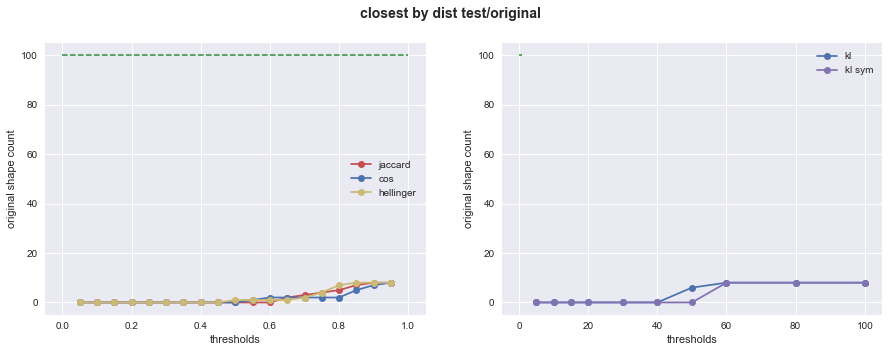

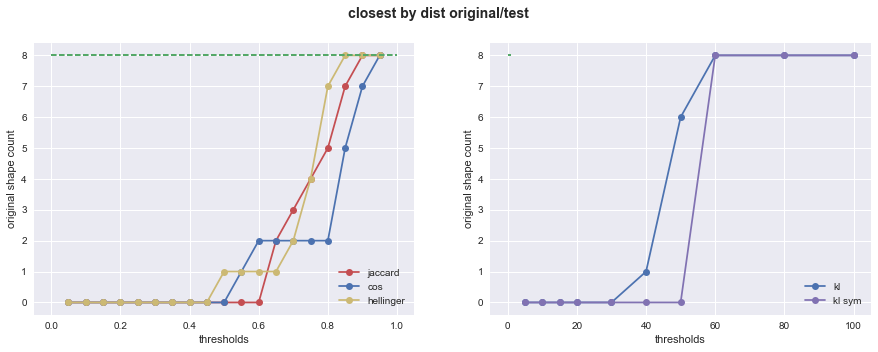

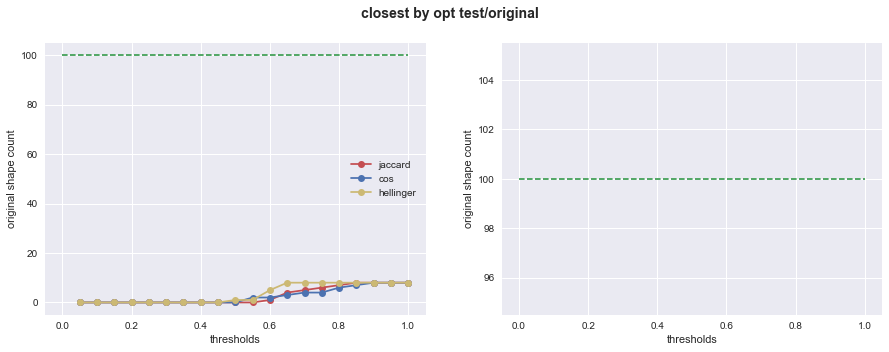

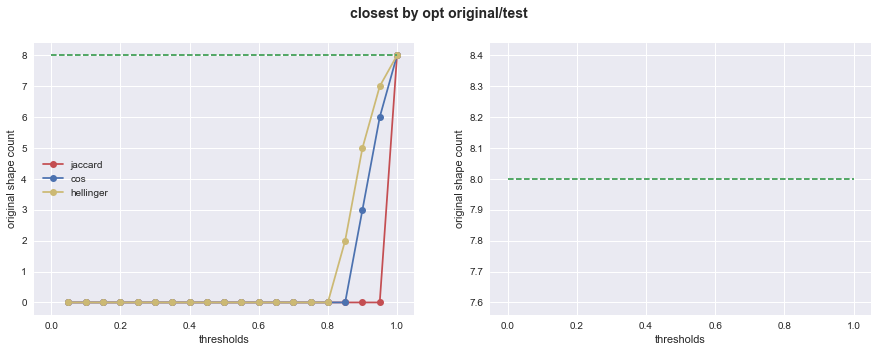

In [12]:
idx = 1
names_list[idx] = [u'model2']
models_list[idx] = create_model_rch3(100)
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])


------------------------------------------------------------ phi ------------------------------------------------------------
topic_1 | фильм: 0.135 кварк: 0.135 культура: 0.105 частица: 0.093 симметрия: 0.075 протон: 0.067 фотон: 0.050 кино: 0.049 масса: 0.049 искусство: 0.039 теория: 0.033 игра: 0.027 природа: 0.020
topic_2 | слово: 0.174 язык: 0.118 женщина: 0.082 текст: 0.056 мужчина: 0.042 буква: 0.032 русский_язык: 0.028 музей: 0.028 значение: 0.022 ребёнок: 0.022 традиция: 0.020 форма: 0.019 культура: 0.019
topic_4 | общество: 0.026 россия: 0.026 отношение: 0.022 страна: 0.022 результат: 0.019 проблема: 0.017 сторона: 0.016 экономика: 0.015 ситуация: 0.015 понятие: 0.015 работа: 0.014 вопрос: 0.013 знание: 0.013
topic_6 | клетка: 0.240 ген: 0.158 организм: 0.132 молекула: 0.072 память: 0.045 процесс: 0.041 функция: 0.039 образ: 0.033 мозг: 0.029 нейрон: 0.028 система: 0.026 сеть: 0.025 вид: 0.017
topic_9 | город: 0.067 власть: 0.059 война: 0.055 страна: 0.051 история: 0.036 имя

phi_1    phi_2
num words                      2216.00  2216.00
num topics                        7.00     8.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2129.29  2144.50
|phi_ij > 0.2| / n_topics         0.14     0.62
|phi_ij > 0.1| / n_topics         1.14     2.00
|phi_ij > 0.01| / n_topics       24.57    18.62
|phi_ij > 0.05| / n_topics        3.29     4.50
|phi_ij > 0.001| / n_topics      80.29    67.50
topic_kernel_average_size        56.43    50.38
topic_kernel_average_purity       0.82     0.80
topic_kernel_average_contrast     0.78     0.76

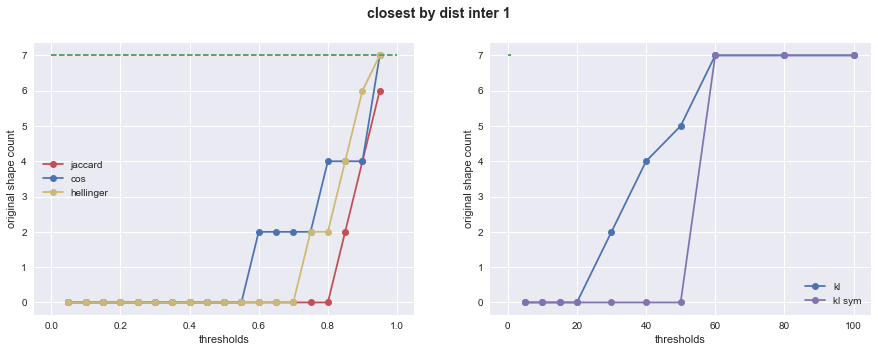

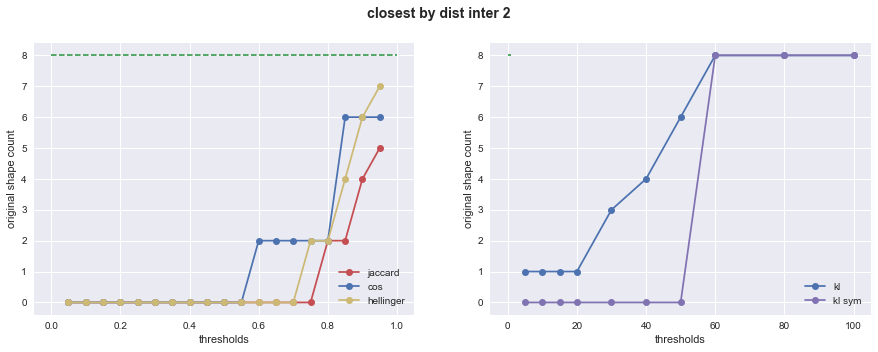

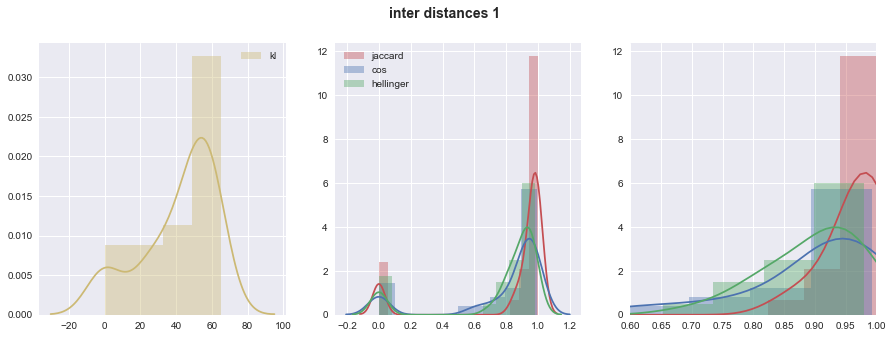

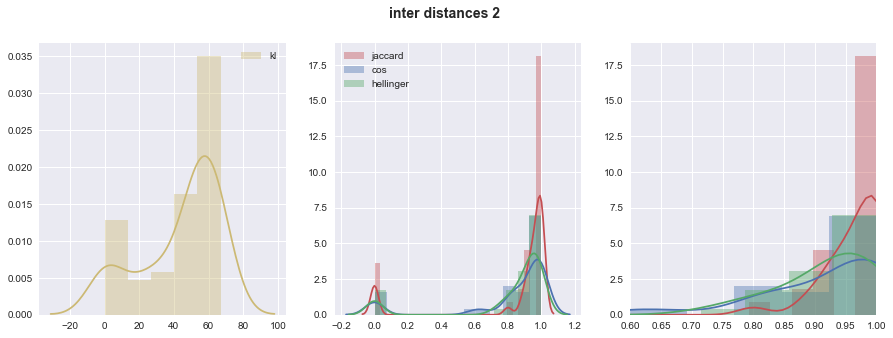

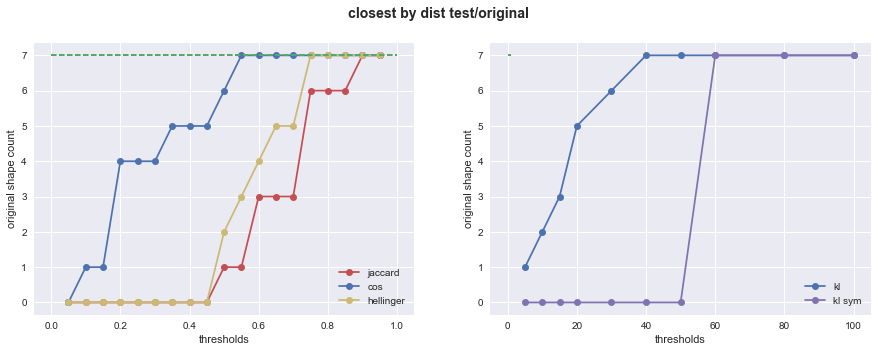

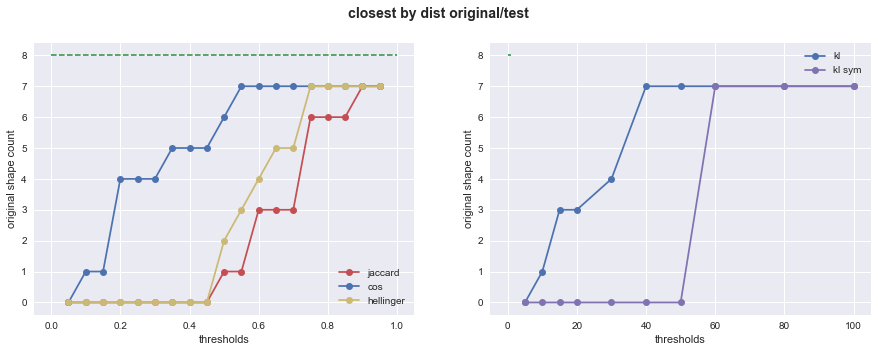

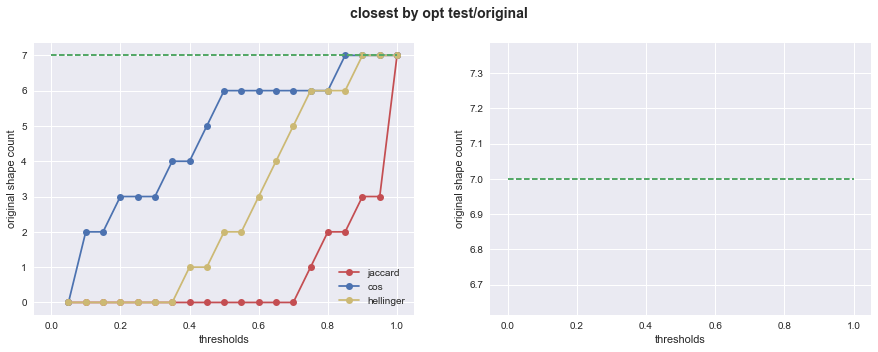

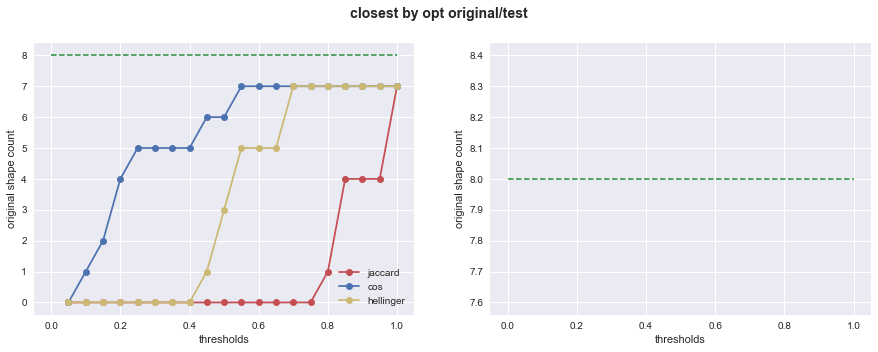

In [22]:
idx = 10
different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_filtered_list[0], phi_filtered_list[1], phi_nwt_filtered_list[0], phi_nwt_filtered_list[1])        

In [27]:
tmp1 = {}
for doc_name, topic in theta_list[0].iteritems():
    tmp1[doc_name] = [(name, val) for name, val in topic.sort_values()[::-1][0:5].iteritems() if val > 1e-3]
tmp2 = {}
for doc_name, topic in theta_list[1].iteritems():
    tmp2[doc_name] = [(name, val) for name, val in topic.sort_values()[::-1][0:5].iteritems() if val > 1e-3]
for key in tmp1.keys():
    if len(tmp1[key]) + len(tmp2[key]) != 0:
        print key, tmp1[key], tmp2[key]
        for topic, val in tmp1[key]:
            print_phi_top_tokens(phi_list[0], topic)            
        for topic, val in tmp2[key]:
            print_phi_top_tokens(phi_list[1], topic)

1 [(u'topic_12', 0.99999994)] [(u'topic_3', 1.0)]
topic_12| звезда: 0.097 галактика: 0.074 земля: 0.070 вселенная: 0.063 солнце: 0.051 чёрный_дыра: 0.045 планета: 0.043 вещество: 0.037 масса: 0.029 наблюдение: 0.025 жизнь: 0.024 поверхность: 0.024 расстояние: 0.023
topic_3| жизнь: 0.020 образ: 0.019 книга: 0.017 объект: 0.016 работа: 0.015 система: 0.015 земля: 0.015 теория: 0.015 исследование: 0.014 звезда: 0.014 вопрос: 0.014 процесс: 0.013 вид: 0.012
2 [(u'topic_18', 1.0)] []
topic_18| книга: 0.039 система: 0.025 работа: 0.024 образ: 0.022 наука: 0.018 метр: 0.017 исследование: 0.017 вопрос: 0.017 вид: 0.016 автор: 0.015 жизнь: 0.015 задача: 0.014 объект: 0.014
4 [(u'topic_2', 0.46169114), (u'topic_14', 0.30944353), (u'topic_18', 0.22886539)] [(u'topic_17', 1.0)]
topic_2| слово: 0.174 язык: 0.118 женщина: 0.082 текст: 0.056 мужчина: 0.042 буква: 0.032 русский_язык: 0.028 музей: 0.028 значение: 0.022 ребёнок: 0.022 традиция: 0.020 форма: 0.019 культура: 0.019
topic_14| язык: 0.998 ис

Странно получается, если выводить для каждого документа темы, которые к которым он относится, то 2 одинаковые модели (20 тем + regs + разные начальные приближения) выдают совсем непохожие темы (см. док 3442, topic18; topic4). 
Это из-за того слишком маленькое число тем?

## Select topics regularizer

In [32]:
def create_model_rch1(n_iteration, fit=True, n_topics=150):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name='model_20_rch1_iter_{}'.format(n_iteration))
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_20_rch1_iter_{}'.format(n_iteration))
    # turn off all other regularizers
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model.regularizers['ss_theta_regularizer'].tau = 0
    tmp_model.regularizers['ss_phi_regularizer'].tau = 0
    # turn on topic selection 
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 2.0
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_20_rch1_iter_{}'.format(n_iteration))    
    return tmp_model

In [33]:
idx = 3
names_list[idx] = [u'model_rch1']
models_list[idx] = create_model_rch1(0)
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

name = model_20_rch1_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_20_rch1_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -5

name = model_20_rch1_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = 0
topic_selection_theta_regularizer, tau = 2.0
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = 0

('Filtered topics: ', [])


После включения topic selection (2.0) всё занулилось, попробовать меньше коэффициент.

name = model_20_rch1_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_20_rch1_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -5

name = model_20_rch2_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = 0
topic_selection_theta_regularizer, tau = 0.1
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = 0

('Filtered topics: ', [u'topic_0', u'topic_4', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   104.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2163.64
|phi_ij > 0.2| / n_topics         0.23     0.63
|phi_ij > 0.1| / n_topics         0.89     1.82
|phi_ij > 0.01| / n_topics       27.16    21.30
|phi_ij > 0.05| / n_topics        2.63     4.70
|phi_ij > 0.001| / n_topics      80.26    37.70
topic_kernel_average_size        23.68    18.44
topic_kernel_average_purity       0.63     0.72
topic_kernel_average_contrast     0.78     0.85

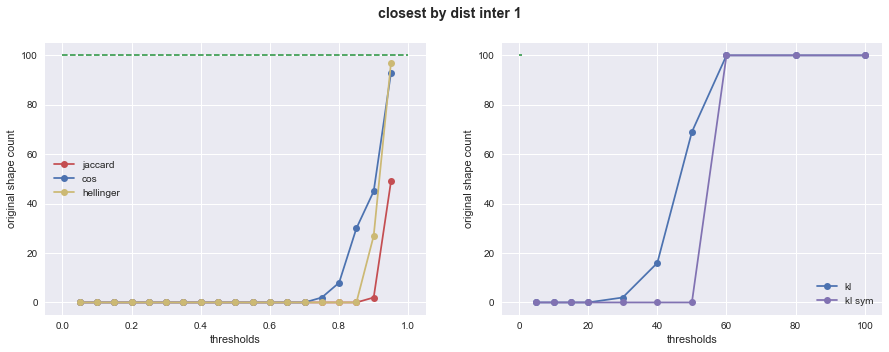

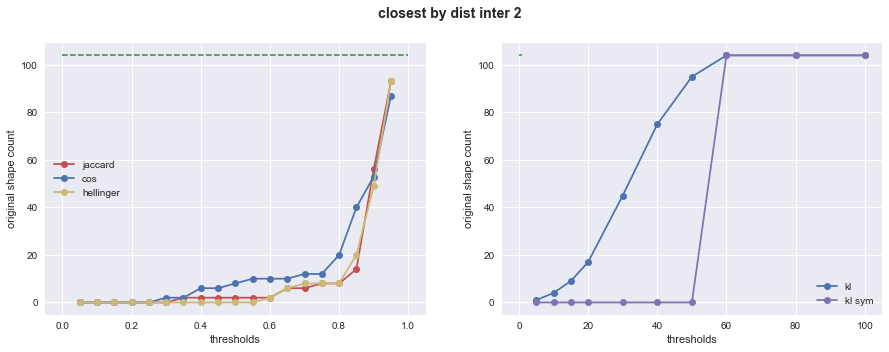

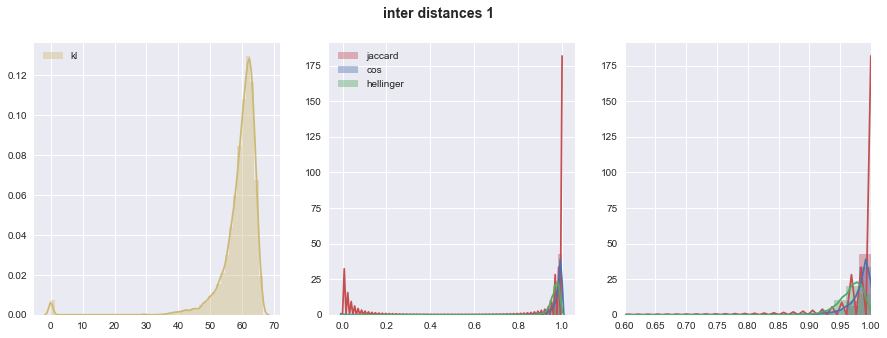

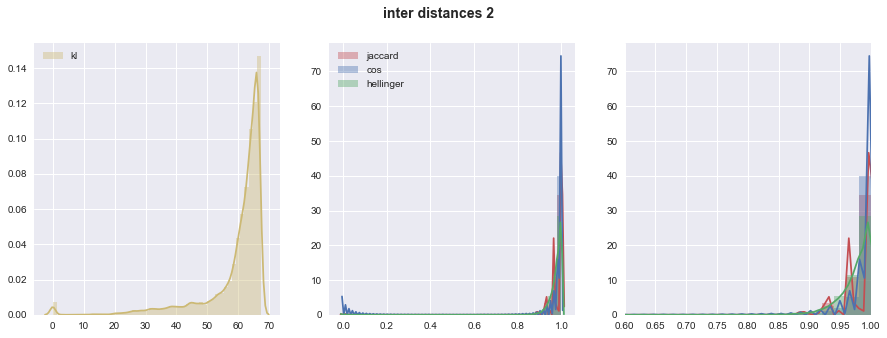

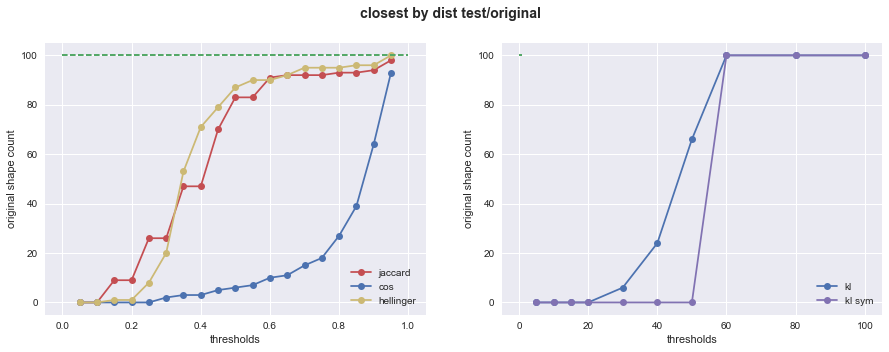

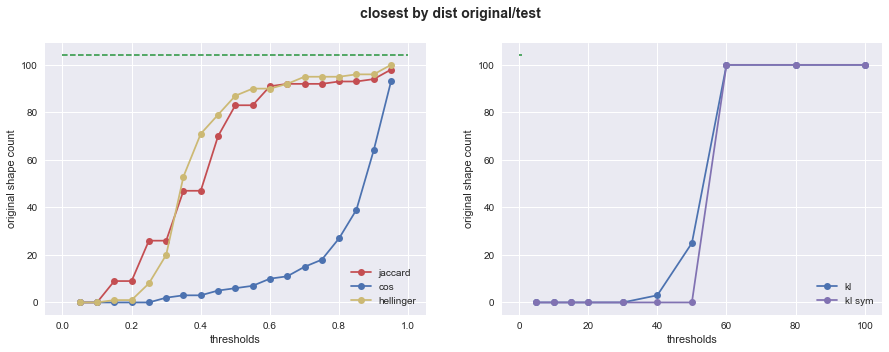

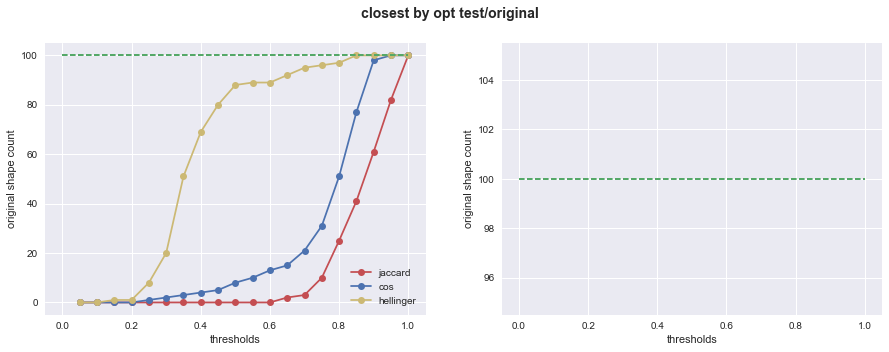

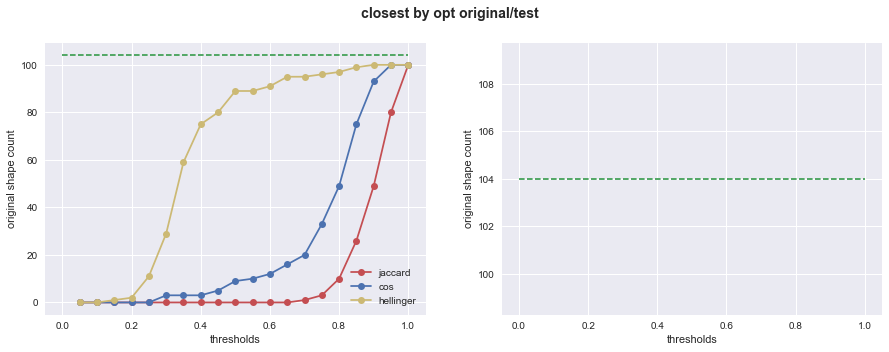

In [37]:
def create_model_rch2(n_iteration, fit=True, n_topics=150):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name='model_20_rch1_iter_{}'.format(n_iteration))
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_20_rch1_iter_{}'.format(n_iteration))
    # turn off all other regularizers
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model.regularizers['ss_theta_regularizer'].tau = 0
    tmp_model.regularizers['ss_phi_regularizer'].tau = 0
    # turn on topic selection 
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.1
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name='model_20_rch2_iter_{}'.format(n_iteration))    
    return tmp_model

idx = 4
names_list[idx] = [u'model_rch2']
models_list[idx] = create_model_rch2(0)
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* от 150 до 104
* phi_ij отличаются, kernel size 24 vs 18, purity 0.63 vs 0.72, contrast 0.78 vs 85 (а если от 125 фильтровать)
* closest by dist: тестовая модель -- темы более близки друг к другу (< 10 topics)
* inter distances: the same
* closest by dist test/original -- 0.2: 10 topics; 0.4: 45-70; 0.6: 90
* closest by dist original/test -- almost the same
* closest by opt res original/test -- hellinger ok; 0.3:40; 0.4:75; 0.5:80, **TODO**: остальные проверить, проверить почему хуже, чем dist, запустить с em

Не будем отключать sparse regularizers, сделаем поменьше их коэффициенты. Побольше коэффициент у topic selection (0.5 vs 0.1)

In [42]:
def create_model_rch3(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    # turn off all other regularizers
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1
    # turn on topic selection 
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)    
    return tmp_model

name = model_rch3_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch3_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -5

name = model_rch3_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.5
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -1

('Filtered topics: ', [u'topic_0', u'topic_4', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   106.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2164.87
|phi_ij > 0.2| / n_topics         0.23     0.39
|phi_ij > 0.1| / n_topics         0.89     1.57
|phi_ij > 0.01| / n_topics       27.16    23.24
|phi_ij > 0.05| / n_topics        2.63     4.42
|phi_ij > 0.001| / n_topics      80.26    49.25
topic_kernel_average_size        23.68    17.99
topic_kernel_average_purity       0.63     0.62
topic_kernel_average_contrast     0.78     0.83

Dist fn = <function kl_sym_dist at 0x000000000BC904A8>, Processed th = 100, original columns count = 106       Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Dist fn = <function cos_dist at 0x000000000BC905F8>, Processed th = 1.0, original columns count = 100           Column topic_7 not optimized
Column topic_17 not optimized
Column topic_26 not optimized
Column topic_27 not optimized
Column topic_28 not optimized
Column topic_40 not optimized
Column topic_42 not optimized
Column topic_5

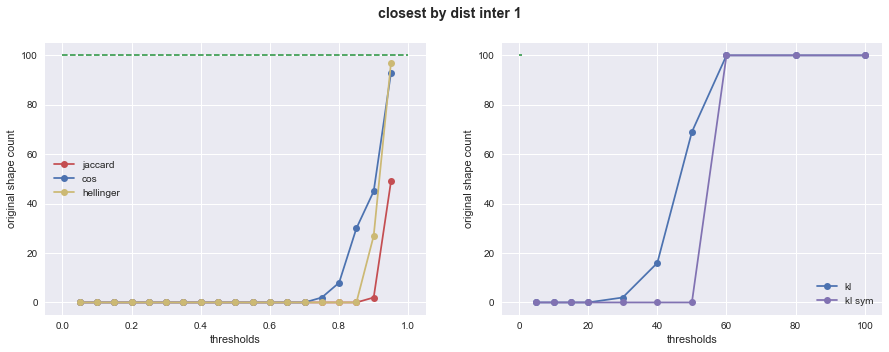

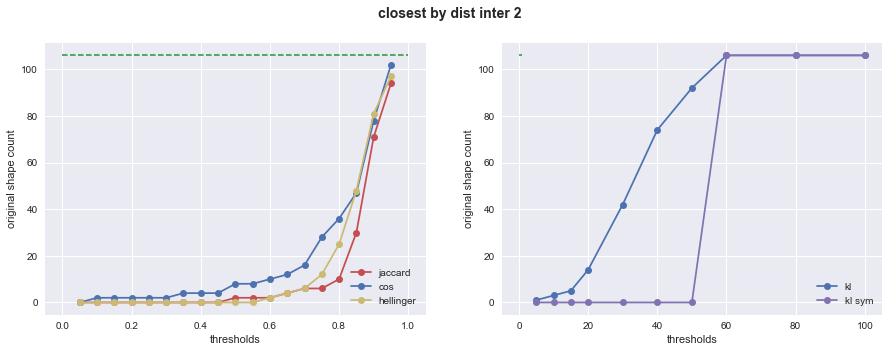

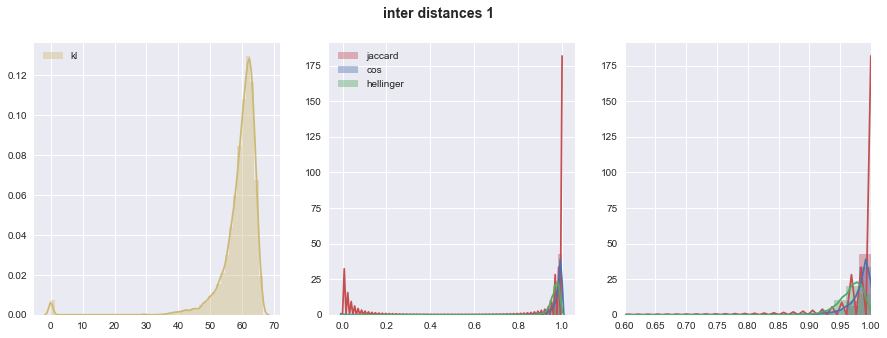

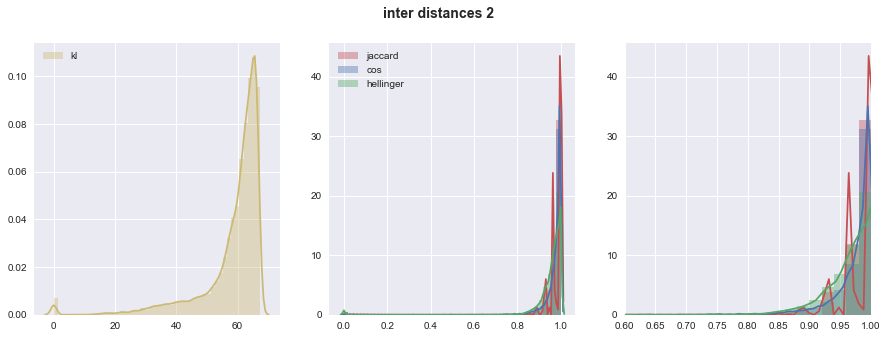

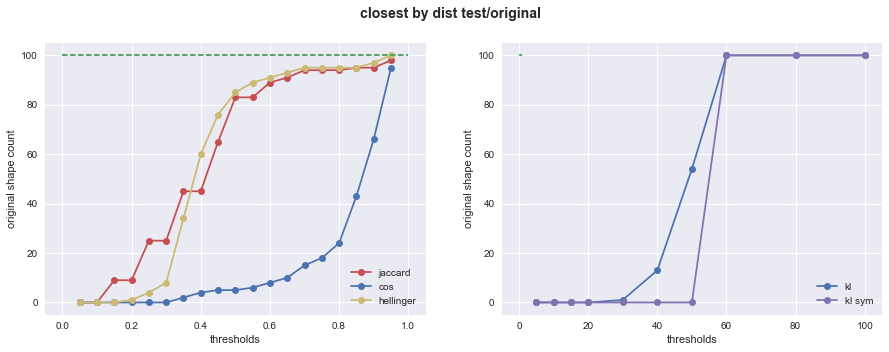

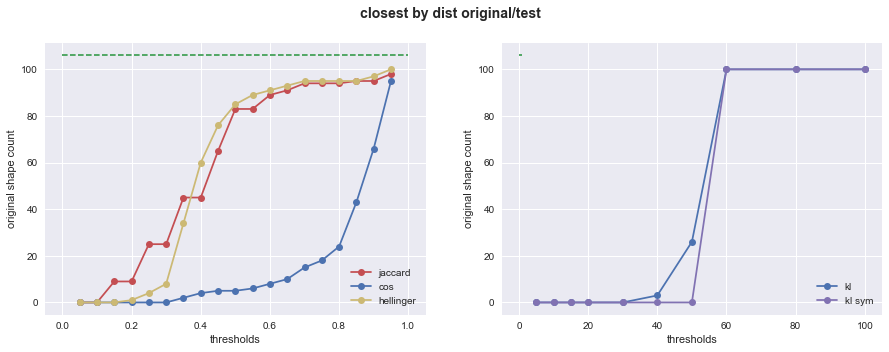

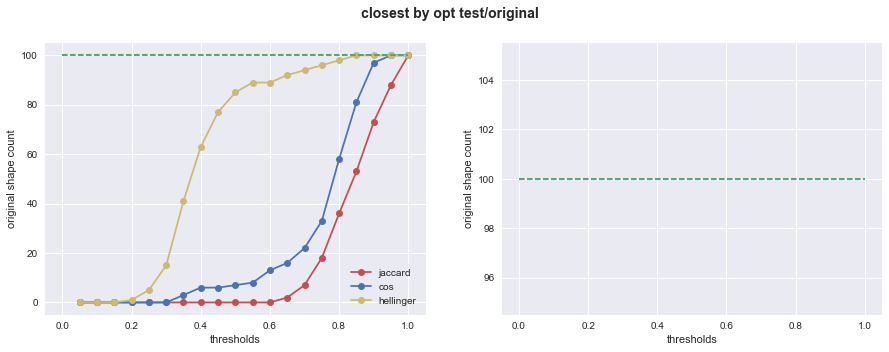

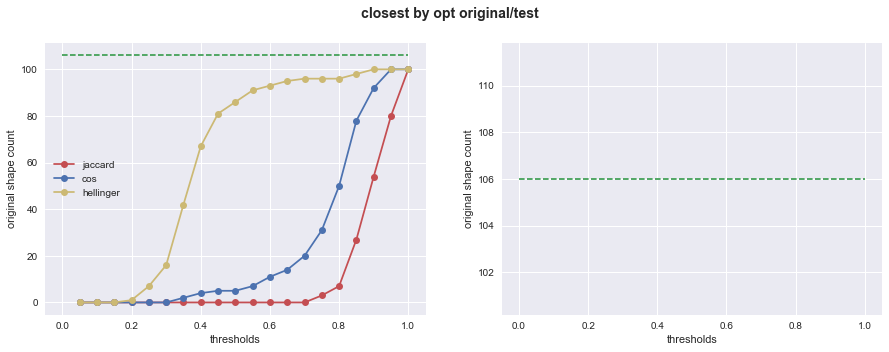

In [43]:
idx = 5
names_list[idx] = u'model_rch3'
models_list[idx] = create_model_rch3(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* от 150 до 106
* phi_ij отличаются, kernel size 24 vs 18, purity .63 vs .62, contrast .78 vs .83 
* closest by dist: тестовая модель -- темы более близки друг к другу (< 10 topics)
* inter distances: the same
* closest by dist test/original -- 0.2: 10 topics; 0.4: 45-60; 0.6: 90
* closest by dist original/test -- almost the same
* closest by opt res original/test -- hellinger ok; 0.3:40; 0.4:75; 0.5:80, **TODO**: остальные проверить, проверить почему хуже, чем dist, запустить с em

Попробуем без декоррелятора, сразу врубать topic selection.

name = model_rch4_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch4_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
ss_phi_regularizer, tau = -5
topic_selection_theta_regularizer, tau = 0.5

name = model_rch4_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
ss_phi_regularizer, tau = -5
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', [u'topic_0', u'topic_4', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_38', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    94.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2152.05
|phi_ij > 0.2| / n_topics         0.23     0.30
|phi_ij > 0.1| / n_topics         0.89     1.30
|phi_ij > 0.01| / n_topics       27.16    24.52
|phi_ij > 0.05| / n_topics        2.63     3.90
|phi_ij > 0.001| / n_topics      80.26    60.55
topic_kernel_average_size        23.68    19.69
topic_kernel_average_purity       0.63     0.59
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BC904A8>, Processed th = 100, original columns count = 94        Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Dist fn = <function cos_dist at 0x000000000BC905F8>, Processed th = 1.0, original columns count = 94           Column topic_18 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_35 not optimized
Column topic_42 not optimized
Column topic_43 not optimized
Column topic_45 not optimized
Column topic_7

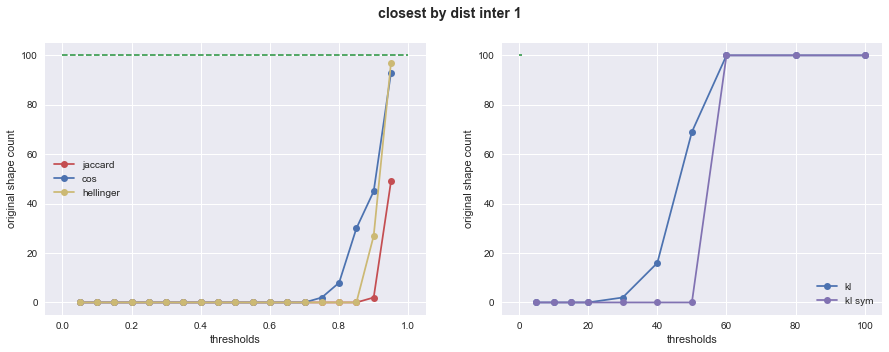

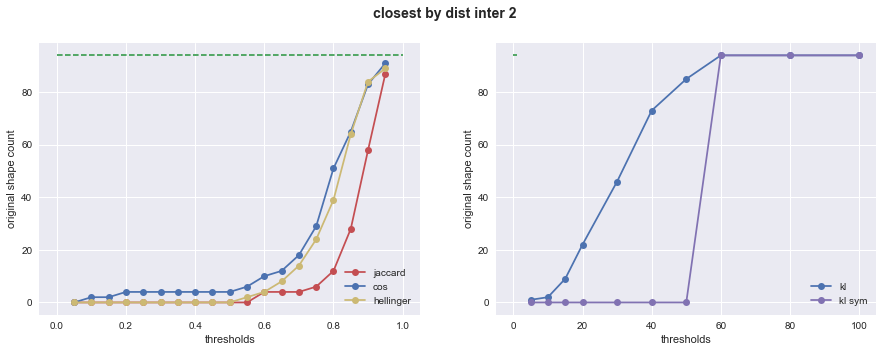

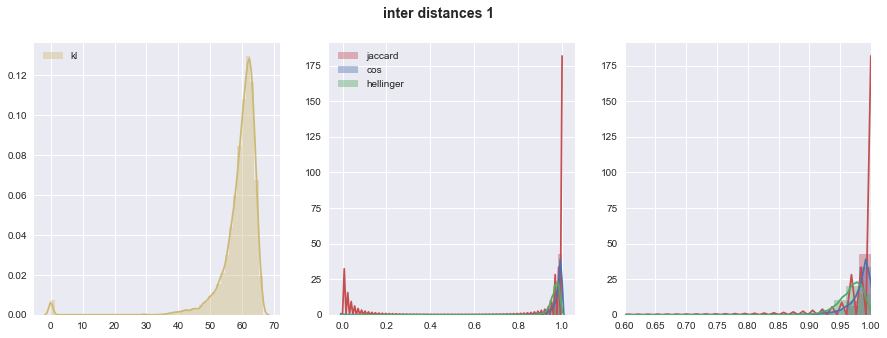

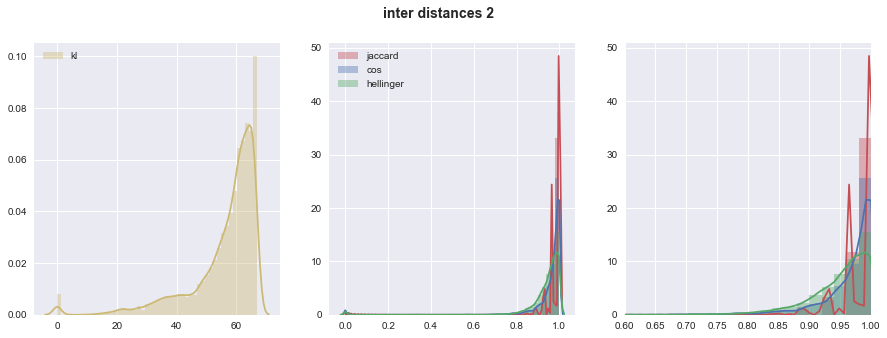

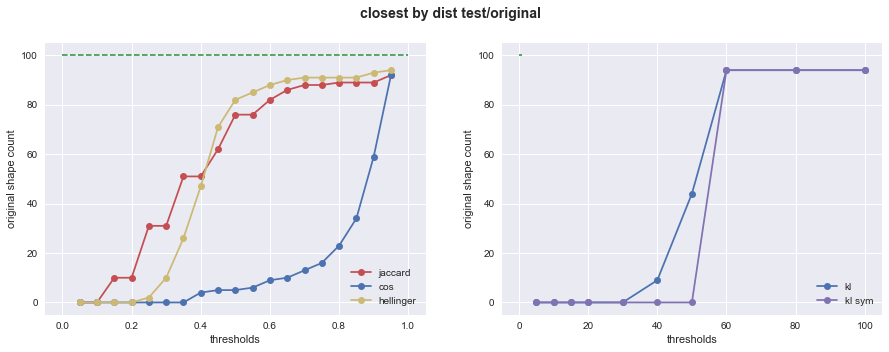

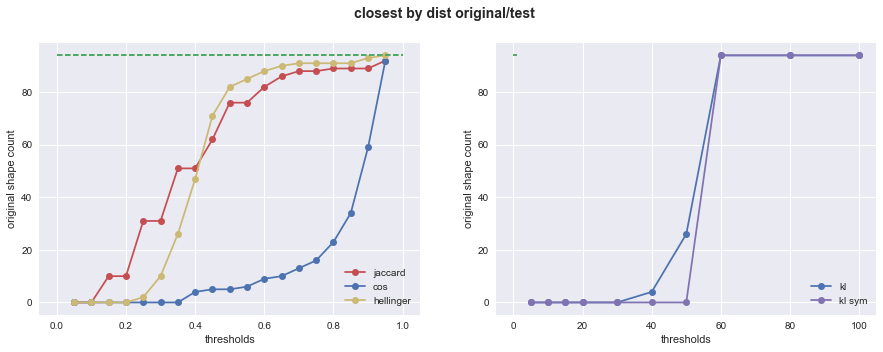

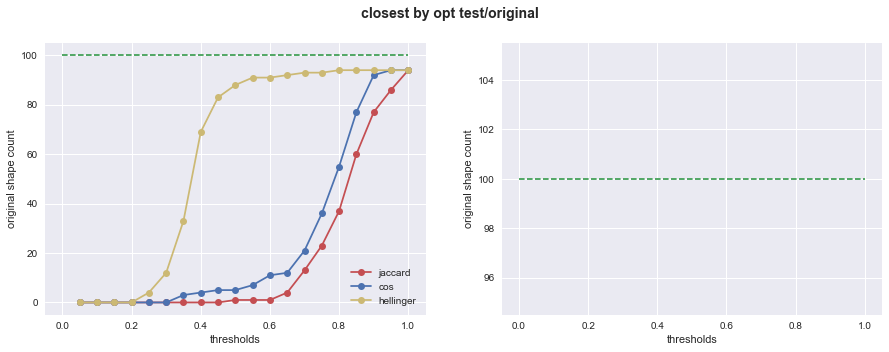

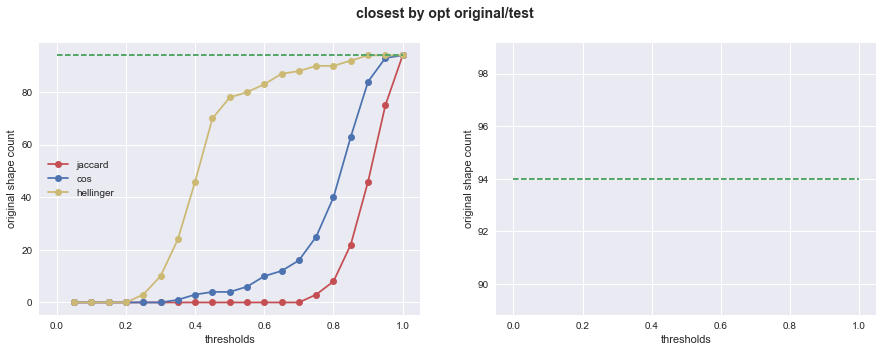

In [45]:
def create_model_rch4(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)    
    return tmp_model

idx = 6
names_list[idx] = u'model_rch4'
models_list[idx] = create_model_rch4(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [48]:
def create_model_rch5(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 1.0
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)    
    return tmp_model

idx = 7
names_list[idx] = u'model_rch5'
models_list[idx] = create_model_rch5(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

name = model_rch5_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch5_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
ss_phi_regularizer, tau = -5
topic_selection_theta_regularizer, tau = 1.0

name = model_rch5_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
ss_phi_regularizer, tau = -5
topic_selection_theta_regularizer, tau = 1.0

('Filtered topics: ', [])


Как model 3, только 125 тем (vs 150).

In [50]:
def create_model_rch6(n_iteration, model_name='', fit=True, n_topics=125):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    # turn off all other regularizers
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1
    # turn on topic selection 
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)    
    return tmp_model

name = model_rch6_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch6_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -5

name = model_rch6_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.5
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -1

('Filtered topics: ', [u'topic_0', u'topic_4', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    97.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2160.53
|phi_ij > 0.2| / n_topics         0.23     0.41
|phi_ij > 0.1| / n_topics         0.89     1.35
|phi_ij > 0.01| / n_topics       27.16    23.53
|phi_ij > 0.05| / n_topics        2.63     4.08
|phi_ij > 0.001| / n_topics      80.26    53.49
topic_kernel_average_size        23.68    19.93
topic_kernel_average_purity       0.63     0.63
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BC904A8>, Processed th = 100, original columns count = 97        Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Dist fn = <function cos_dist at 0x000000000BC905F8>, Processed th = 1.0, original columns count = 97           Column topic_7 not optimized
Column topic_16 not optimized
Column topic_17 not optimized
Column topic_27 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_41 not optimized
Column topic_50

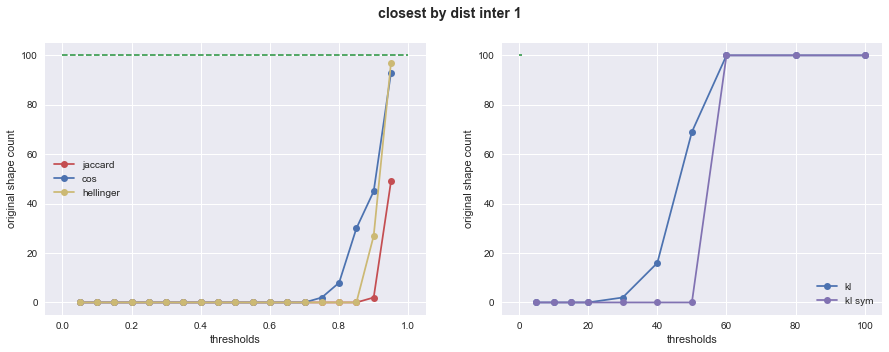

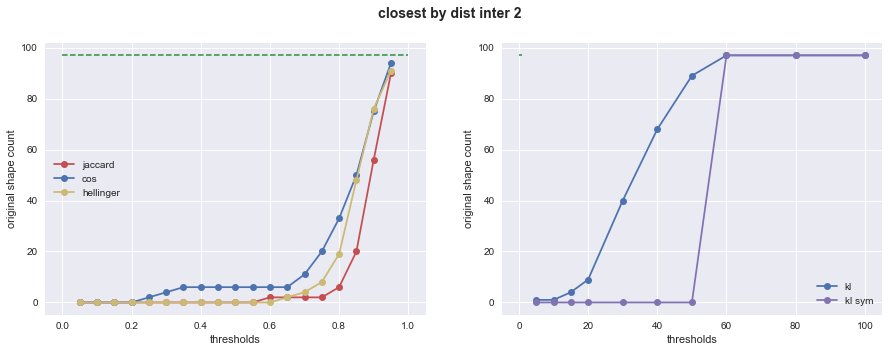

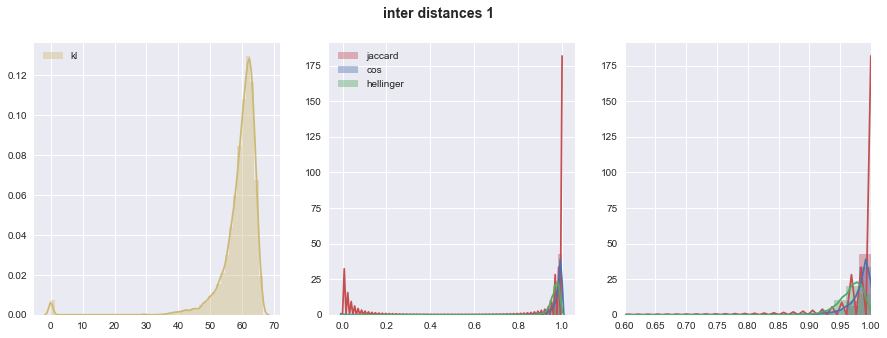

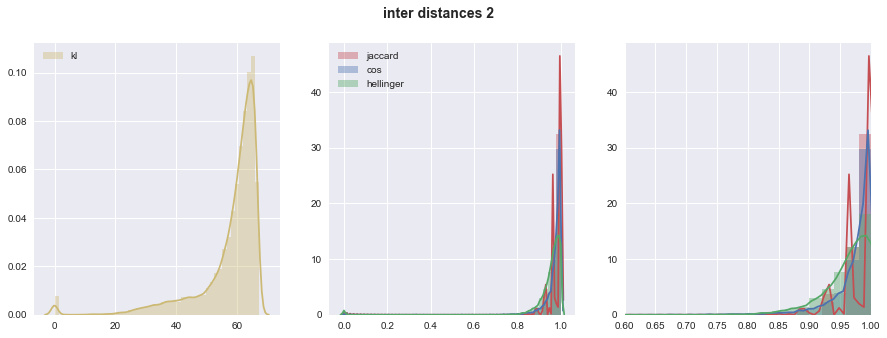

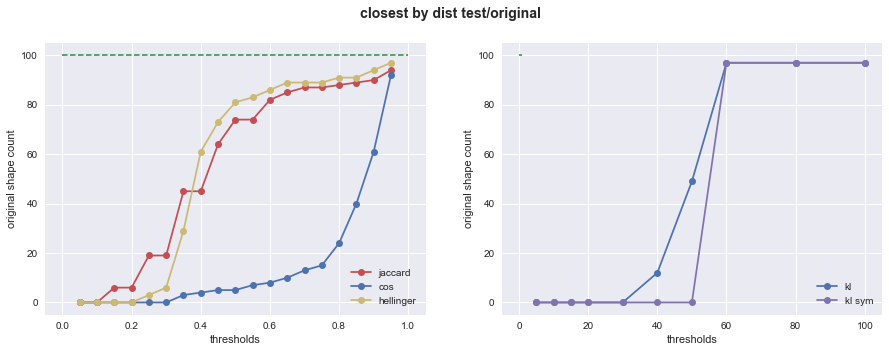

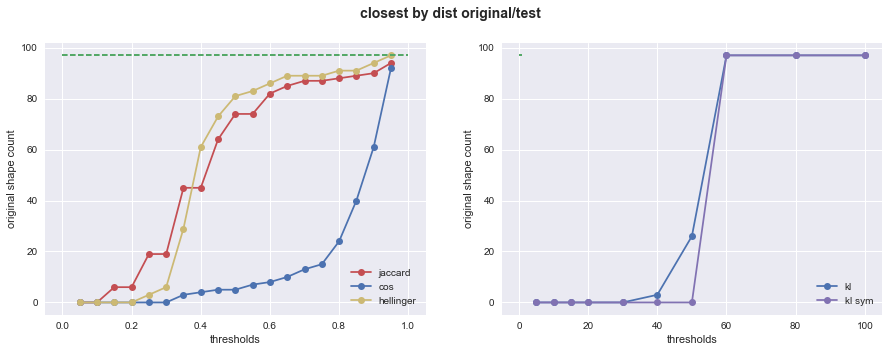

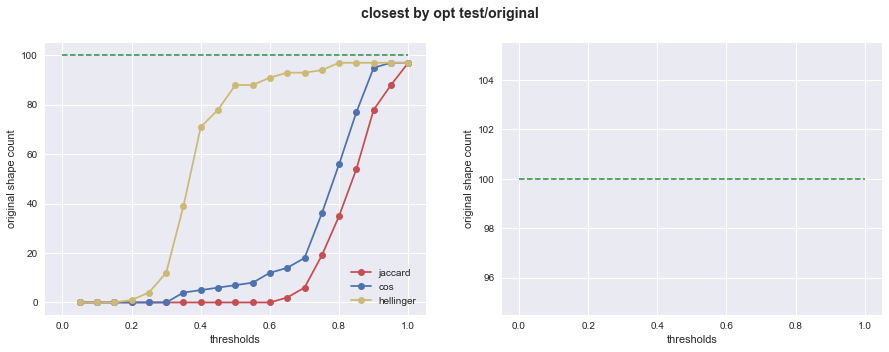

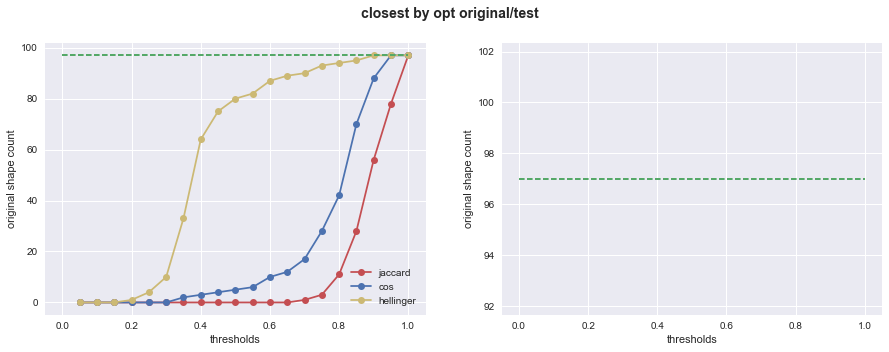

In [51]:
idx = 8
names_list[idx] = u'model_rch6'
models_list[idx] = create_model_rch6(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

Уменьшим коэффициент декорреляции.

In [53]:
def create_model_rch7(n_iteration, model_name='', fit=True, n_topics=125):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -4
    tmp_model.regularizers['ss_phi_regularizer'].tau = -4
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    # turn off all other regularizers
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1
    # turn on topic selection 
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)    
    return tmp_model

name = model_rch7_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch7_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -4
decorrelator_phi_regularizer, tau = 5
ss_phi_regularizer, tau = -4

name = model_rch7_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -1

('Filtered topics: ', [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_27', u'topic_28', u'topic_29', u't

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   101.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2160.47
|phi_ij > 0.2| / n_topics         0.23     0.47
|phi_ij > 0.1| / n_topics         0.89     1.37
|phi_ij > 0.01| / n_topics       27.16    23.63
|phi_ij > 0.05| / n_topics        2.63     4.16
|phi_ij > 0.001| / n_topics      80.26    52.96
topic_kernel_average_size        23.68    19.72
topic_kernel_average_purity       0.63     0.62
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BC904A8>, Processed th = 100, original columns count = 101       Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Dist fn = <function cos_dist at 0x000000000BC905F8>, Processed th = 1.0, original columns count = 100           Column topic_7 not optimized
Column topic_16 not optimized
Column topic_17 not optimized
Column topic_28 not optimized
Column topic_35 not optimized
Column topic_54 not optimized
Column topic_63 not optimized
Column topic_8

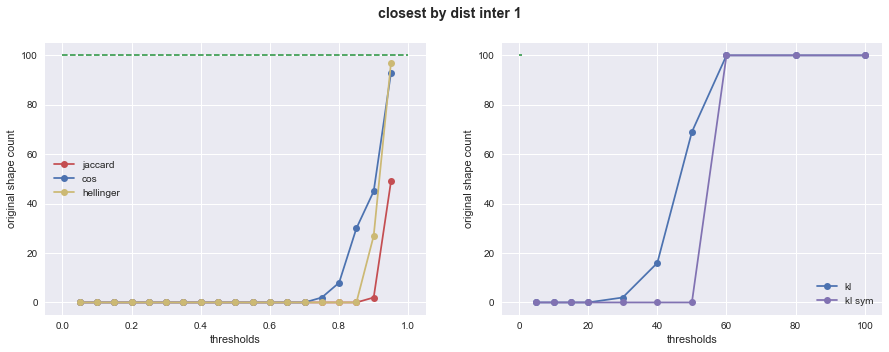

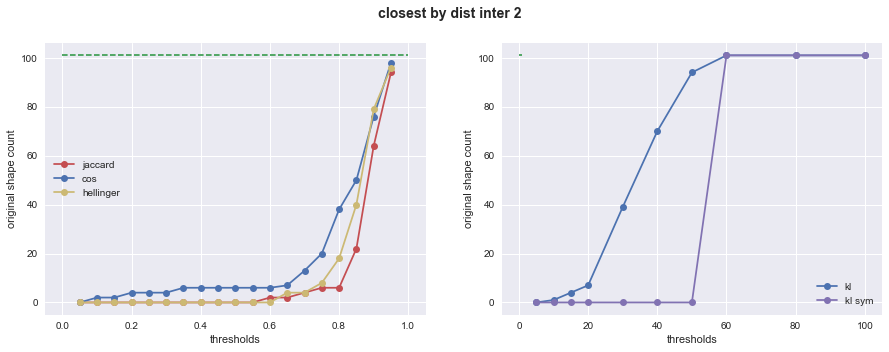

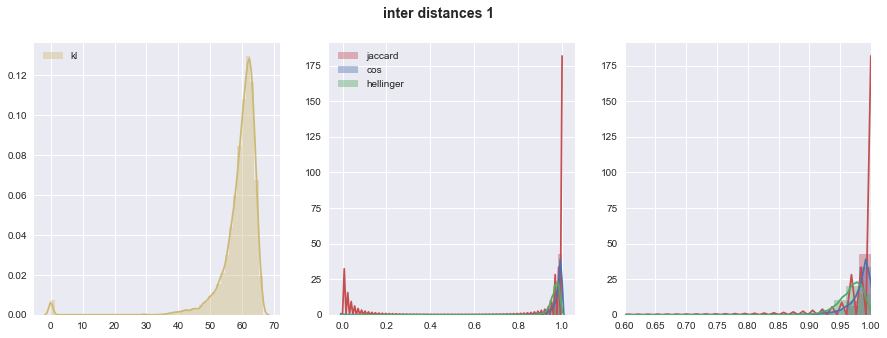

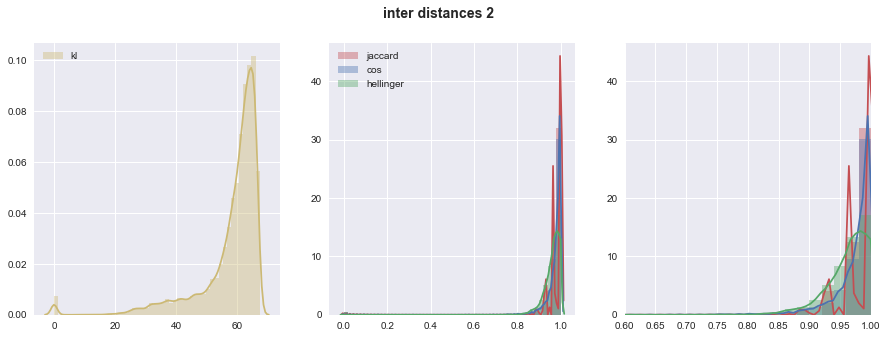

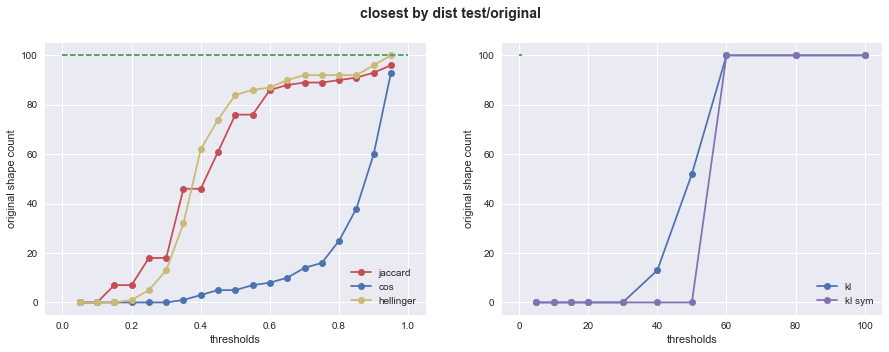

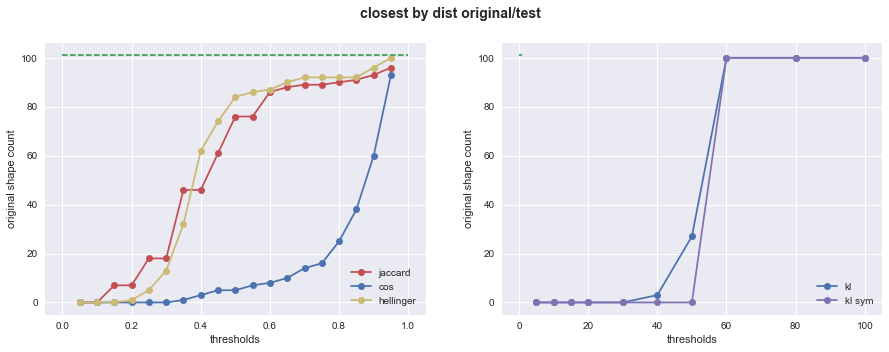

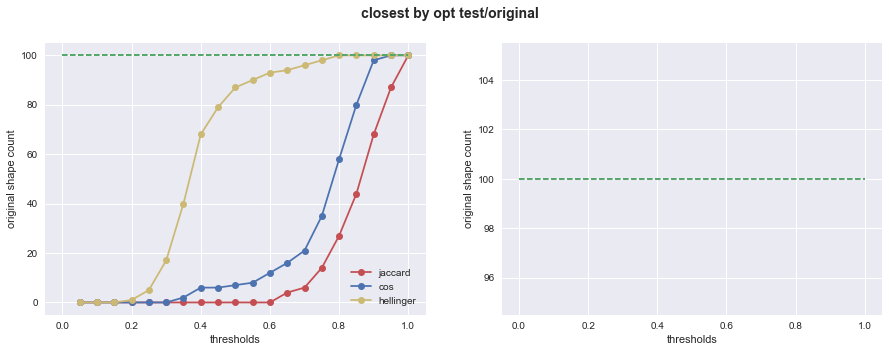

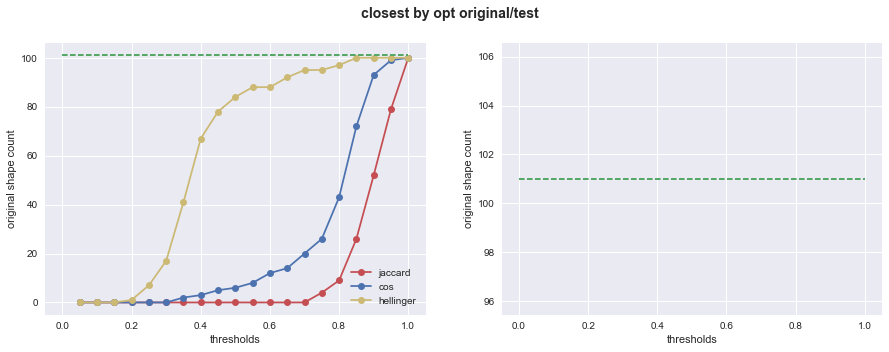

In [54]:
idx = 9
names_list[idx] = u'model_rch7'
models_list[idx] = create_model_rch7(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [ ]:
# уменьшим  декоррелятор и спарсе вначале

In [55]:
def create_model_rch11(n_iteration, model_name='', fit=True, n_topics=125):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 2
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    # turn off all other regularizers
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1
    # turn on topic selection 
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    if fit:
        tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)    
    return tmp_model

name = model_rch11_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch11_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 2
ss_phi_regularizer, tau = -1.5

name = model_rch11_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 20, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -1

('Filtered topics: ', [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23'

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   122.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2159.20
|phi_ij > 0.2| / n_topics         0.23     0.43
|phi_ij > 0.1| / n_topics         0.89     1.29
|phi_ij > 0.01| / n_topics       27.16    23.59
|phi_ij > 0.05| / n_topics        2.63     4.11
|phi_ij > 0.001| / n_topics      80.26    53.66
topic_kernel_average_size        23.68    18.07
topic_kernel_average_purity       0.63     0.55
topic_kernel_average_contrast     0.78     0.77

Dist fn = <function kl_sym_dist at 0x000000000BC904A8>, Processed th = 100, original columns count = 122        Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Dist fn = <function cos_dist at 0x000000000BC905F8>, Processed th = 1.0, original columns count = 100           Column topic_14 not optimized
Column topic_24 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_36 not optimized
Column topic_48 not optimized
Column topic_53 not optimized
Column topic

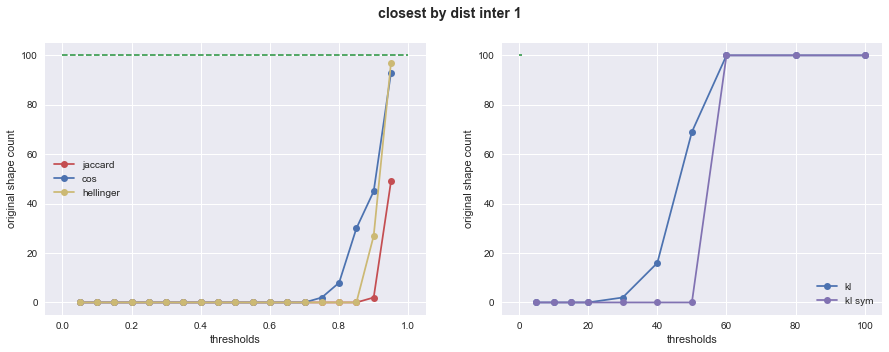

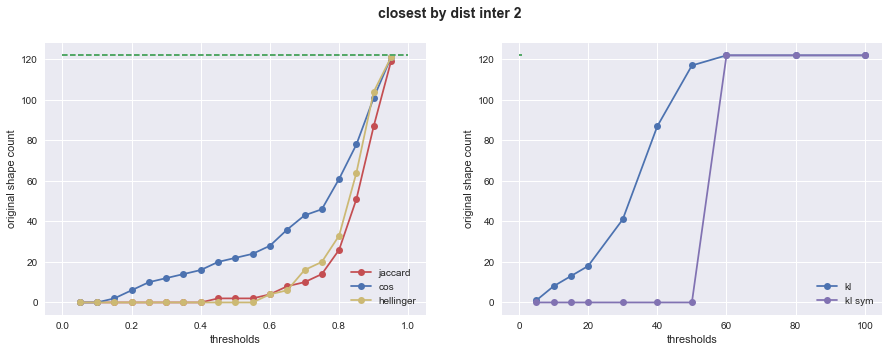

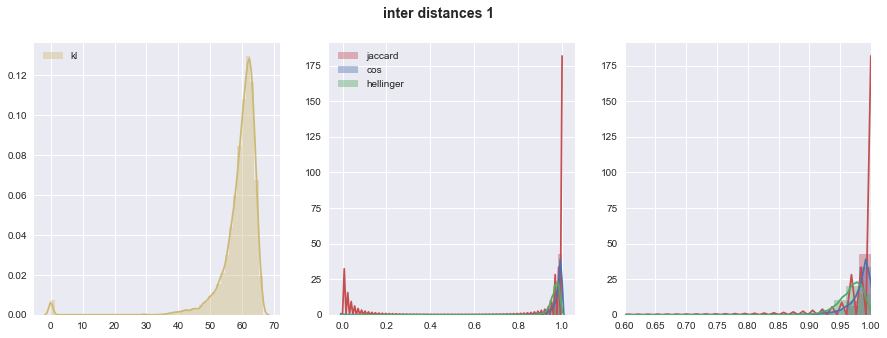

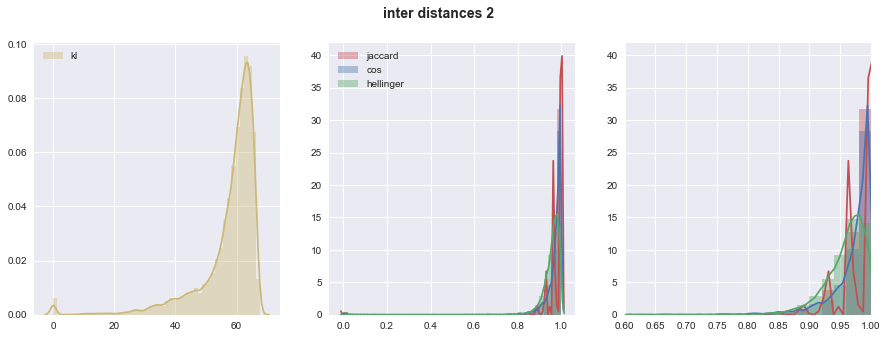

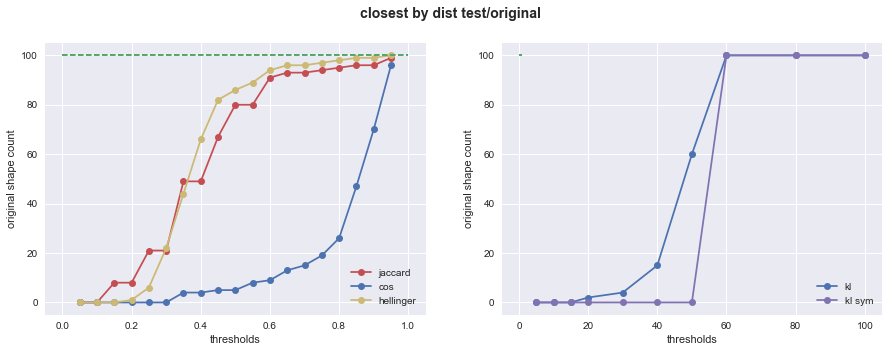

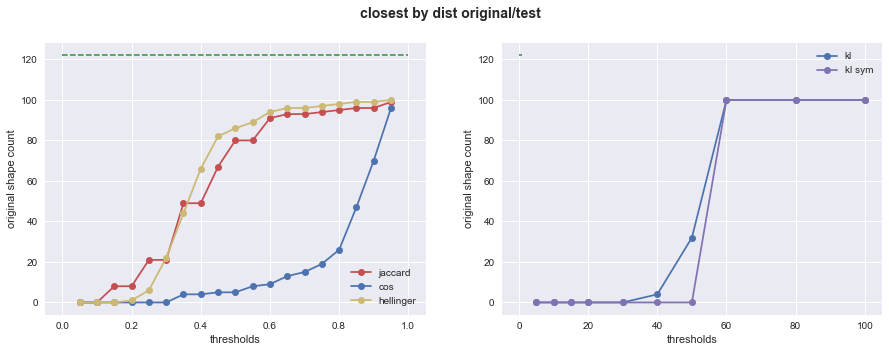

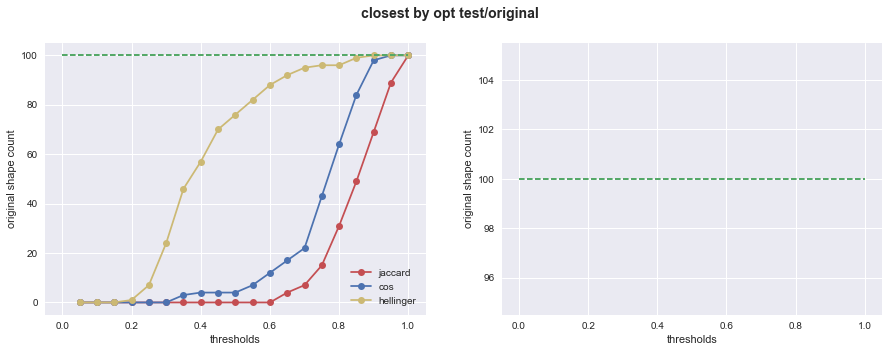

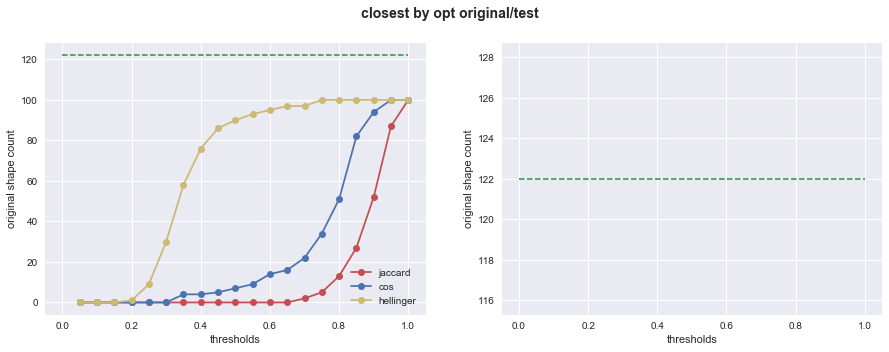

In [56]:
idx = 11
names_list[idx] = u'model_rch11'
models_list[idx] = create_model_rch11(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* contrast стал ближе, purity дальше .55 vs .63, size 24 vs 18 (особо не меняется)
 
 сразу отбор

In [57]:
def create_model_rch12(n_iteration, model_name='', fit=True, n_topics=125):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.3
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

name = model_rch12_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch12_iter_0, n_topics = 125, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.3

('Filtered topics: ', [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   117.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2149.79
|phi_ij > 0.2| / n_topics         0.23     0.42
|phi_ij > 0.1| / n_topics         0.89     1.16
|phi_ij > 0.01| / n_topics       27.16    24.18
|phi_ij > 0.05| / n_topics        2.63     3.86
|phi_ij > 0.001| / n_topics      80.26    59.61
topic_kernel_average_size        23.68    18.78
topic_kernel_average_purity       0.63     0.53
topic_kernel_average_contrast     0.78     0.77

Dist fn = <function kl_sym_dist at 0x000000000BC904A8>, Processed th = 100, original columns count = 117        Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Processing <function jaccard_dist at 0x000000000BC90518>
Processing <function cos_dist at 0x000000000BC905F8>
Processing <function hellinger_dist at 0x000000000BC90668>
Processing <function kl_dist at 0x000000000BC0A748>
Processing <function kl_sym_dist at 0x000000000BC904A8>
Dist fn = <function cos_dist at 0x000000000BC905F8>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_17 not optimized
Column topic_25 not optimized
Column topic_27 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_41 not optimized
Column topic_

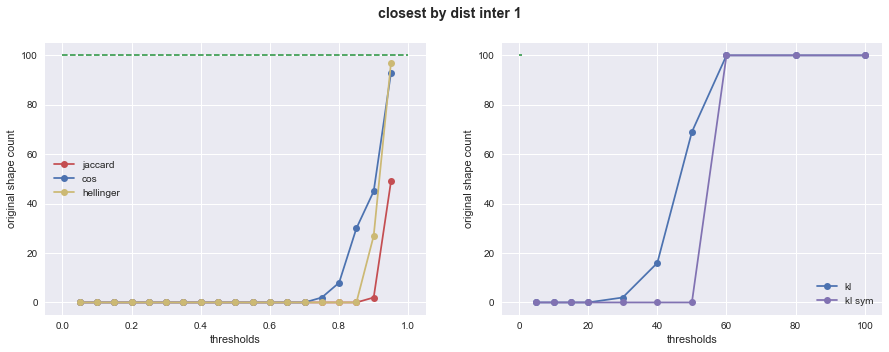

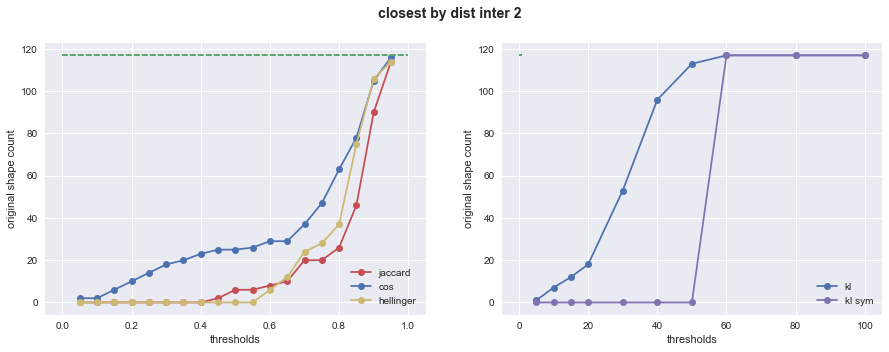

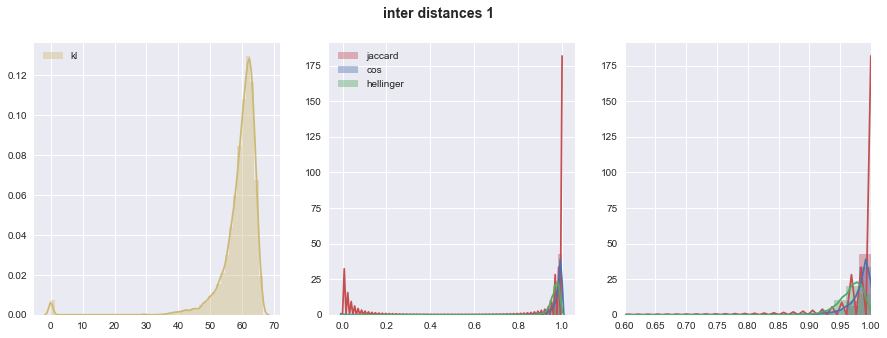

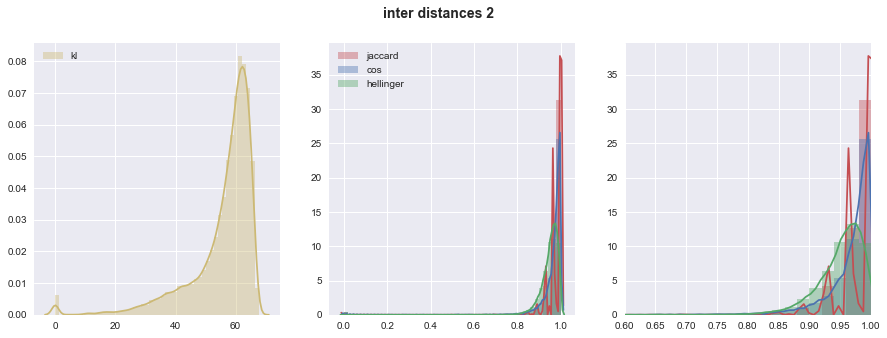

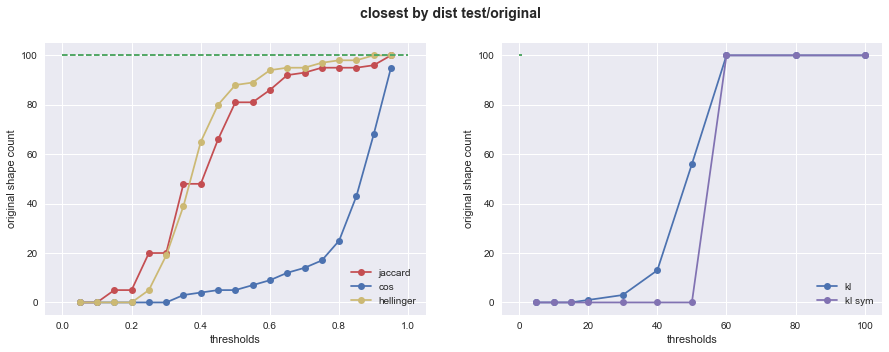

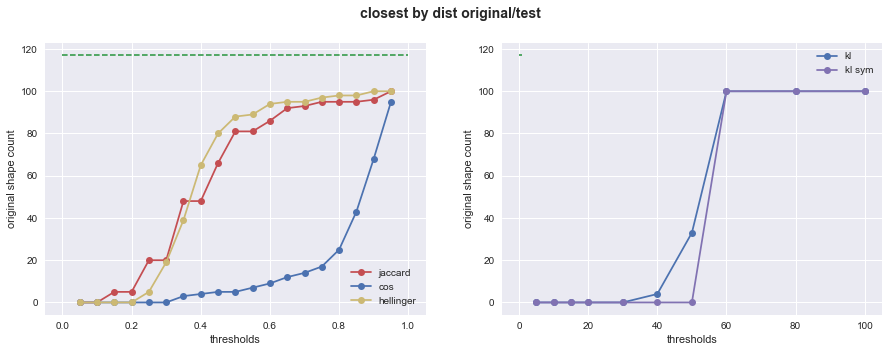

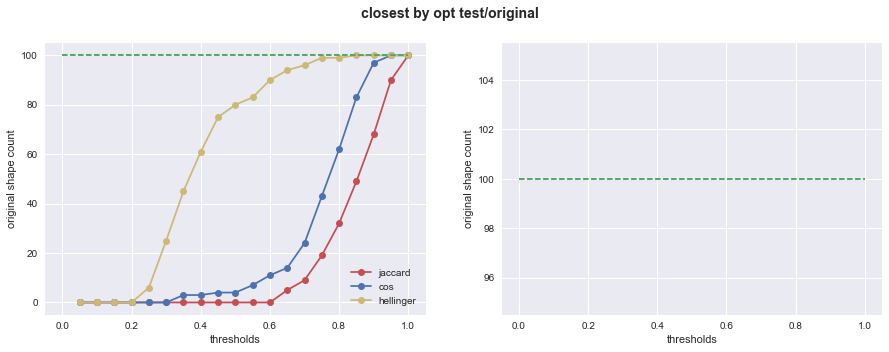

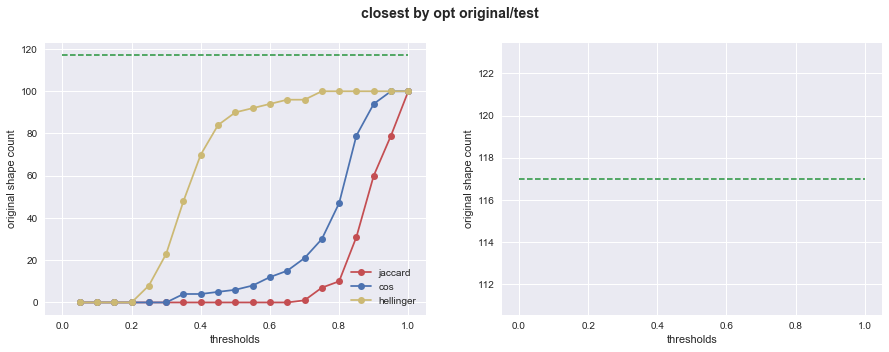

In [58]:
idx = 12
names_list[idx] = u'model_rch12'
models_list[idx] = create_model_rch12(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])